In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_PATH = Path('/content/drive/My Drive/ML_Training_Data/inverse-of-neural-net')

Mounted at /content/drive


In [2]:
from pathlib import Path

# INPUT_PATH = Path('../inputs/mnist/cnn')
# OUTPUT_PATH = Path('../outputs/mnist/cnn')
INPUT_PATH = DRIVE_PATH / 'inputs/mnist/cnn'
OUTPUT_PATH = DRIVE_PATH / 'outputs/mnist/cnn'

INPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(999)


class Net(nn.Module):
    def __init__(self, in_dim, in_channel, out_size):
        super(Net, self).__init__()
#         layer1 = self.get_conv_relu_maxpool(in_channel, 10, 2, 2)
#         layer2 = self.get_conv_relu_maxpool(10, 20, 3, 2)
#         layer1_out = layer1(torch.rand((1, 1, 28, 28)))
#         layer2_out = layer2(layer1_out)
#         print(f'conv outs={layer1_out.size()}, {layer2_out.size()}')
#         layer3 = nn.Linear(layer2_out.flatten(1).size(-1), int(layer2_out.flatten(1).size(-1)/2))
#         layer4 = nn.Linear(int(layer2_out.flatten(1).size(-1)/2), out_size)
#         self.layers = nn.ModuleList([layer1, layer2, layer3, layer4])
        layer1 = self.get_conv_relu_maxpool(in_channel, 20, 3, 2)
        
        layer1_out = layer1(torch.rand((1, 1, 28, 28)))
        print(f'conv outs={layer1_out.size()}')
        layer2 = nn.Linear(layer1_out.flatten(1).size(-1), int(layer1_out.flatten(1).size(-1)/2))
        layer3 = nn.Linear(int(layer1_out.flatten(1).size(-1)/2), out_size)
        self.layers = nn.ModuleList([layer1, layer2, layer3])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and len(x.size()) > 2:
                x = x.flatten(1)
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_conv_relu_maxpool(self, in_channel, num_filters, kernel_size, pool_size):
        return nn.Sequential(nn.Conv2d(in_channel, num_filters, kernel_size),
                             nn.ReLU(),
                             nn.MaxPool2d(pool_size))
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size,
               'shuffle': True}
test_kwargs = {'batch_size': batch_size,
              'shuffle': True}

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST(INPUT_PATH/'mnist', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST(INPUT_PATH/'mnist', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net(28, 1, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model, model(torch.rand(2, 1, 28, 28).to(device)).size()

conv outs=torch.Size([1, 20, 13, 13])


(Net(
   (layers): ModuleList(
     (0): Sequential(
       (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (1): Linear(in_features=3380, out_features=1690, bias=True)
     (2): Linear(in_features=1690, out_features=10, bias=True)
   )
 ), torch.Size([2, 10]))

In [ ]:
len(train_loader)*batch_size

60032

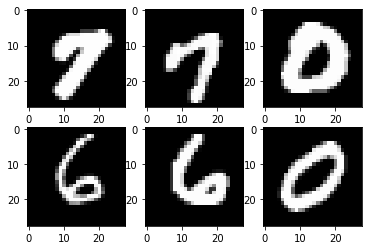

In [4]:
from matplotlib import pyplot as plt

examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Target Model Training

If you have not already trained a model, uncomment the next cell and run it

In [ ]:
# import copy
# import warnings
# warnings.filterwarnings("ignore") 

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         # print(data.size(), data.view(data.size(0), -1).size())
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            

# def test():
#     with torch.no_grad():
#         n_correct = 0
#         n_samples = 0
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             # max returns (value ,index)
#             _, predicted = torch.max(outputs.data, 1)
#             n_samples += labels.size(0)
#             n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')
#     return acc


# best_acc = -1
# best_model = None
# for epoch in range(1, 20):
#     train(model, device, train_loader, optimizer, epoch)
#     acc = test()
#     if acc > best_acc:
#         best_acc = acc
#         best_model = copy.deepcopy(model)
#         print(f'new best acc={best_acc}')
#     else:
#         print(f'current acc={acc}, prev_best_acc={best_acc}')

# state = {
#     'model_state': best_model.state_dict(),
#     'test_acc': best_acc
# }
# torch.save(state, OUTPUT_PATH/'state_4layer_nn.pt')
# print('best model saved')
# 98.75

### Reverse Model Training

In [5]:
state = torch.load(OUTPUT_PATH/'state_3layer_nn.pt')
state.keys()

dict_keys(['model_state', 'test_acc'])

In [6]:
model.load_state_dict(state['model_state'])
model.to(device)

for param in model.parameters():
    param.requires_grad = False
                                 
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Linear(in_features=3380, out_features=1690, bias=True)
    (2): Linear(in_features=1690, out_features=10, bias=True)
  )
)

In [7]:
config_dict = {
    'epochs': 3000,
    'alpha': 1,
    'lr': 1e-3,
    'lr_sched': 'exp',
    'gamma': 0.99,
    'loss': 'abs',
    'min_lr': 1e-5,
    'leaky_relu': 0.5,
    'conv_actv': 'selu',
    'use_bn': False,
    'batch_size': 128,
    'init_method': 'lecun_normal',
}

In [ ]:
def get_stats():
    train_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = True, download= True,
                             transform=transforms.ToTensor())
    dataloader = torch.utils.data.DataLoader(train_qmnist, batch_size=128)
    nimages = 0
    mean = 0.0
    var = 0.0
    for i_batch, batch_target in enumerate(dataloader):
        batch = batch_target[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)

    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    return mean, std

In [ ]:
model(torch.rand((1, 1, 28, 28)).to(device))
[print(val.size()) for val in model.forward_vals]

torch.Size([1, 20, 13, 13])
torch.Size([1, 1690])
torch.Size([1, 10])


[None, None, None]

In [26]:
from torch.nn.init import xavier_normal_, xavier_uniform_
from torch.nn.init import zeros_, uniform_, _calculate_correct_fan, normal_
from torch.nn.init import kaiming_uniform_, kaiming_normal_

class InvNet(nn.Module):
    def __init__(self, out_dim, out_channel, tgt_model):
        super(InvNet, self).__init__()
        
        layers = []
        for i, tgt_layer in enumerate(tgt_model.layers[::-1], 1):
            if isinstance(tgt_layer, nn.Sequential):
                tgt_layer = tgt_layer[0]
            
            if isinstance(tgt_layer, nn.Linear):
                if len(tgt_model.forward_vals[-i-1].size()) > 2:
                    out_size = tgt_model.forward_vals[-i-1].flatten(1).size(-1)
                    self.first_conv_dim = tgt_model.forward_vals[-i-1].size()
                else:
                    out_size = tgt_model.forward_vals[-i-1].size(-1)
                layer = self.get_linear_with_relu(tgt_model.forward_vals[-i].size(-1), out_size, config_dict['use_bn'])
            elif isinstance(tgt_layer, nn.Conv2d):
                if i < len(tgt_model.layers):
                    out_channel = tgt_model.forward_vals[-i-1].size(1)
                    layer = self.get_conv_relu(tgt_model.forward_vals[-i].size(1), out_channel, 3, 1, 5, 1, 
                                               True if len(config_dict['conv_actv'])>0 else False,
                                              config_dict['use_bn'])
                else:
                    out_channel = 1
                    layer = self.get_upsample_and_conv(tgt_model.forward_vals[-i].size(1), out_channel, 3, 1, 0, 1, False, False)
                
            layers.append(layer)

        self.conv_type = type(layers[-1][0])
        self.layers = nn.ModuleList(layers)
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for i, layer in enumerate(self.layers):
            if isinstance(layer[0], self.conv_type) and len(x.size()) <= 2:
                x = x.view(x.size(0), self.first_conv_dim[1], self.first_conv_dim[2], self.first_conv_dim[3])  # out dims of conv2d of target model
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_conv_relu(self, in_channel, num_filters, kernel_size, stride, padding, dilation, use_actv=True, use_bn=False):
        sequential = nn.Sequential(nn.Conv2d(in_channel, num_filters, kernel_size, 
                                                    stride=stride, padding=padding, dilation=dilation,
                                                    bias=True))
        
        if use_bn:
            sequential.add_module('bn', nn.BatchNorm2d(num_filters))
        
        if use_actv:
            sequential.add_module('actv', self.get_activation(config_dict['conv_actv']))
            
        return sequential

    def get_upsample_and_conv(self, in_channel, num_filters, kernel_size, stride, padding, dilation, use_actv=True, use_bn=False):
        sequential = nn.Sequential(nn.Upsample(size=30, mode='bilinear'),
            nn.Conv2d(in_channel, num_filters, kernel_size,
                                                    stride=stride, padding=padding, dilation=dilation,
                                                    bias=True)
            )
        
        if use_bn:
            sequential.add_module('bn', nn.BatchNorm2d(num_filters))
        
        if use_actv:
            sequential.add_module('actv', self.get_activation(config_dict['conv_actv']))
            
        return sequential

    def get_activation(self, actv):
        if actv == 'relu':
            return nn.LeakyReLU(config_dict['leaky_relu'])
        elif actv == 'selu':
            return nn.SELU()
        elif actv == 'tanh':
            return nn.Tanh()
    
    def get_linear_with_relu(self, inp, out, use_bn):
        sequential =  nn.Sequential(nn.Linear(inp, out))
        if use_bn:
            sequential.add_module('lin_bn', nn.BatchNorm1d(out))
        
        sequential.add_module('lin_actv', self.get_activation(config_dict['conv_actv']))
        return sequential


def lecun_normal_(weight, mode):
    fan = _calculate_correct_fan(weight, mode)
    print(fan)
    limit = torch.sqrt(3/torch.tensor(fan))
    normal_(weight, -limit, limit)


def init_weights(layer):
    def init_(data):
        if config_dict['init_method'] == 'he_normal':
            kaiming_normal_(data, a=config_dict['leaky_relu'], nonlinearity='selu')
        elif config_dict['init_method'] == 'xavier_normal':
            xavier_normal_(data)
        elif config_dict['init_method'] == 'lecun_normal':
            lecun_normal_(data, 'fan_in') 

    if isinstance(layer, nn.Linear):
        init_(layer.weight)
        # zeros_(layer.bias)
    elif isinstance(layer, nn.Conv2d):
        init_(layer.weight)
        # zeros_(layer.bias)


inv_model = InvNet(28, 1, model)
inv_model.apply(init_weights)
inv_model.to(device)
# mean, std = get_stats()
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

batch_size = config_dict['batch_size']
test_kwargs = {'batch_size': batch_size,
              'shuffle': True}
train_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = True, download= True,
                             transform=transform) 
test_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = False, download= True,
                             transform=transform)

print(f'size of inv data={train_qmnist}')
inv_data_loader = torch.utils.data.DataLoader(train_qmnist, **test_kwargs)

if config_dict['loss'] == 'mse':
    loss_fn = nn.MSELoss()
elif config_dict['loss'] == 'huber':
    loss_fn = nn.HuberLoss()
else:
    loss_fn = nn.L1Loss()

optimizer = optim.Adam(inv_model.parameters(), lr=config_dict['lr'])

lr_sched = None
if config_dict['lr_sched'] == 'exp':
    lr_sched = optim.lr_scheduler.ExponentialLR(optimizer, config_dict['gamma'], verbose=False)

print(inv_model)
o = inv_model(torch.rand((2, 10)).to(device))
print(f'out_size={o.size()}')
[val.size() for val in inv_model.forward_vals], inv_model.first_conv_dim

10
1690
180
size of inv data=Dataset QMNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/ML_Training_Data/inverse-of-neural-net/inputs/mnist/cnn/qmnist
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
InvNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=1690, bias=True)
      (lin_actv): SELU()
    )
    (1): Sequential(
      (0): Linear(in_features=1690, out_features=3380, bias=True)
      (lin_actv): SELU()
    )
    (2): Sequential(
      (0): Upsample(size=30, mode=bilinear)
      (1): Conv2d(20, 1, kernel_size=(3, 3), stride=(1, 1))
    )
  )
)
out_size=torch.Size([2, 1, 28, 28])


([torch.Size([2, 1690]), torch.Size([2, 3380]), torch.Size([2, 1, 28, 28])],
 torch.Size([1, 20, 13, 13]))

In [28]:
# s = []
# for batch, tgt in inv_data_loader:
#     s.append((batch[0].unsqueeze(0), tgt[0]))
#     s.append((batch[1].unsqueeze(0), tgt[1]))
#     break
# len(inv_data_loader), len(s)# inv_model(torch.rand((1, 10, )).to(device)).size()

In [ ]:
# for t in s:
#     print(t[0].size(), t[1])

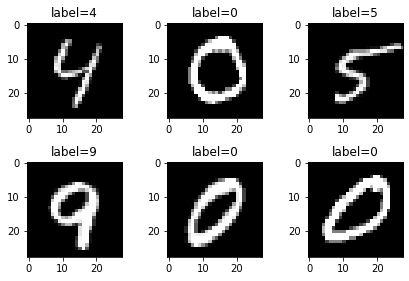

In [9]:
from matplotlib import pyplot as plt
import random

for i in range(6):
    example_data, example_target = test_qmnist[random.randint(0, len(test_qmnist))]
    ax = plt.subplot(2,3,i+1)
    ax.set_title(f'label={example_target}')
    plt.imshow(example_data.squeeze(), cmap='gray')
plt.tight_layout()
plt.show()

In [10]:
def get_layer_map(model):
    layer_map = {}
    for i in range(len(model.layers)):
        layer_map[i] = len(model.layers)-(i+1)
    print(f'layer_map={layer_map}')
    return layer_map

In [11]:
def layer_wise_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_in = inp if layer_num == 0 else model.forward_vals[layer_num-1]  # get the input tensor for this layer in tgt model
        tgt_layer_out = model.forward_vals[layer_num]  # get the output of i-th target model layer 
        inv_layer = inv_model.layers[tgt_to_inv_layer_map[layer_num]]  # get the corresponding layer in reverse model
        inv_layer_out = inv_layer(tgt_layer_out)  # feed the target model layer output to reverse model layer
        if inv_layer_out.size(-1) != tgt_layer_in.size(-1):
            tgt_layer_in = tgt_layer_in.flatten(1)
        loss += loss_fn(inv_layer_out, tgt_layer_in)  # outputs of both layer should be similar
        
    return loss


def k_layer_loss(model, inv_model, inp, k=-1):
    loss = 0
    for layer_num, layer_ in enumerate(model.layers[:k+1] if k > -1 else model.layers):
        tgt_layer_out = model.forward_vals[layer_num]
        x = tgt_layer_out
        for layer in inv_model.layers[-(1+layer_num):]:
            if isinstance(layer[0], inv_model.conv_type) and len(x.size()) < 4:
                x = x.view(x.size(0), inv_model.first_conv_dim[1], inv_model.first_conv_dim[2], inv_model.first_conv_dim[3])
            x = layer(x)
        loss += loss_fn(x, inp)
    
    return loss


def cycle_consistency_inversion_loss(model, inp, inv_out, k=-1):
    org_activations = copy.deepcopy(model.forward_vals[:k+1] if k > -1 else model.forward_vals)
    out_for_inv_input = model(inv_out)  # pass the input image generated by inverted network
    inv_activations = model.forward_vals[:k+1] if k > -1 else model.forward_vals
    loss = 0
    for org_actv, actv in zip(org_activations, inv_activations):
        loss += loss_fn(actv, org_actv)
        
    return loss

### all loss together

In [12]:
import copy

tgt_to_inv_layer_map = get_layer_map(model)

def train_inv(model, inv_model, device, data_loader, optimizer, epoch, alpha, layer_wise_only=False, layer_num=-1):
    model.train()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        if not layer_wise_only:
            # step 2- upto layer-k loss
            loss_img = k_layer_loss(model, inv_model, data)

            # step 3- full network output loss
            loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        else:
            loss_img = torch.tensor(0)
            loss_cyc = torch.tensor(0)
        
        loss = loss_layer + loss_img + (alpha*loss_cyc)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_layer += loss_layer.item()
        total_loss_img += loss_img.item()
        total_loss_cyc += loss_cyc.item()
        
    return total_loss / (batch_idx+1), total_loss_layer / (batch_idx+1), \
            total_loss_img / (batch_idx+1), total_loss_cyc / (batch_idx+1)

layer_map={0: 2, 1: 1, 2: 0}


### gradual loss calculation

In [13]:
import copy

tgt_to_inv_layer_map = get_layer_map(model)

def train_inv_gradual(model, inv_model, device, data_loader, optimizer, epoch, alpha):
    model.train()

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        loss = loss_layer
        
        loss.backward()
        optimizer.step()

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        # step 2- upto layer-k loss
        loss_img = k_layer_loss(model, inv_model, data)
        
        loss = loss_layer + loss_img
        
        loss.backward()
        optimizer.step()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        # step 2- upto layer-k loss
        loss_img = k_layer_loss(model, inv_model, data)

        # step 3- full network output loss
        loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        
        loss = loss_layer + loss_img + (alpha*loss_cyc)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_layer += loss_layer.item()
        total_loss_img += loss_img.item()
        total_loss_cyc += loss_cyc.item()
        
    return total_loss / (batch_idx+1), total_loss_layer / (batch_idx+1), \
            total_loss_img / (batch_idx+1), total_loss_cyc / (batch_idx+1)

layer_map={0: 2, 1: 1, 2: 0}


In [ ]:
run_id = '3layer_upsample_nonGradual_lecunNormalInit_selu'  # '3layer_xavierUniformInit_largerLR3e-4'
change_desc = '3 layer, upsample+conv2d, non-gradual loss calc, lecunNorm, selu actv, no actv on last conv layer'
is_resume = True
run_path = OUTPUT_PATH/'runs'/run_id
state_path = run_path/'final_state_3layer_inv_nn.pt'
best_model_path = run_path/'state_3layer_inv_nn.pt'

!pip install wandb

### uncomment and run below cells for LR finder graph

In [ ]:
# len(inv_data_loader)

In [ ]:
# import numpy as np

# losses = []
# lrs = []
# lr_low = 1e-6
# lr_high = 10
# step = np.exp(np.log(10**7)/700)
# lr = lr_low
# alpha = config_dict['alpha']

# while len(lrs) == 0 or lrs[-1] < lr_high:
#     for batch_idx, (data, target) in enumerate(inv_data_loader):
#         data, target = data.to(device), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
#         optimizer.zero_grad()

#         out = model(data)  
#         inv_out = inv_model(out)
        
#         # step 1- layer wise load
#         loss_layer = layer_wise_loss(model, inv_model, data)
        
#         # step 2- upto layer-k loss
#         loss_img = k_layer_loss(model, inv_model, data)

#         # step 3- full network output loss
#         loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        
#         loss = loss_layer + loss_img + (alpha*loss_cyc)
        
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())
#         lrs.append(lr)

#         if lr >= lr_high:
#             break
        
#         lr = lr*step

# print(f'len of lists {len(losses)}, {len(lrs)}')

In [ ]:
# from matplotlib import pyplot as plt

# plt.figure(figsize=(25, 10))
# # plt.xticks(np.log(lrs), ['{:0.3e}'.format(i) for i in lrs])
# plt.plot(np.log10(lrs), losses)
# lr_finder_path = run_path/f'{run_id}_lr_finder1.png'
# run_path.mkdir(parents=True, exist_ok=True)
# plt.savefig(lr_finder_path)
# plt.show()

### Training code

In [ ]:
import time
import sys
import wandb
import os
import numpy as np


def round_(n, d=5):
    return np.round(n, d)


run_path.mkdir(parents=True, exist_ok=True)

EPOCHS = config_dict['epochs']
ALPHA = config_dict['alpha']
start_epoch = 0
prev_best_loss = 999999
total_training_time = 0

if is_resume and state_path.exists():
    state = torch.load(state_path)
    inv_model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer'])
    if lr_sched:
        lr_sched.load_state_dict(state['lr_sched'])
    start_epoch = state['epoch']+1
    prev_best_loss = state['prev_best_loss']

    print(f'resuming training for {run_id} from epoch {start_epoch}, last loss {state["loss"]} prev_best_loss {prev_best_loss}')
    

wandb.init(project='nn-are-reversible',
           entity='nayash', save_code=True, id=run_id,
           name=run_id, notes=change_desc,
           dir=run_path,
           resume='allow',
           config=config_dict)
wandb.watch(inv_model)
wand.log({'model_arch': str(inv_model)})

if run_id in ['test', 'temp']:
    os.environ['WANDB_MODE'] = 'offline'
    print(f'run_id={run_id}, so wandb is disabled!')
          
for epoch in range(start_epoch, EPOCHS):
    stime = time.time()
    total_loss, total_loss_layer, total_loss_img, total_loss_cyc = \
        train_inv(model, inv_model, device, inv_data_loader, optimizer, epoch, ALPHA)

    epoch_time = time.time() - stime
    total_training_time += epoch_time
    
    print(f'epoch={epoch}/{EPOCHS} loss={round_(total_loss)}, loss_layer={round_(total_loss_layer)}, loss_img={round_(total_loss_img)}, loss_cyc={round_(total_loss_cyc)}, epoch_duration={round(epoch_time)} secs')
    
    wandb.log({
        'loss':total_loss,
        'loss_layer':total_loss_layer,
        'loss_img':total_loss_img,
        'loss_cyc':total_loss_cyc,
        'lr': optimizer.param_groups[0]['lr']
    })
    
    if lr_sched is not None and optimizer.param_groups[0]['lr'] > config_dict['min_lr']:
        lr_sched.step()
    
    if total_loss < prev_best_loss:
        prev_best_loss = total_loss
        state = {
            'model_state': inv_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': lr_sched.state_dict() if lr_sched else None,
            'epoch': epoch,
            'loss': prev_best_loss,
            'prev_best_loss': prev_best_loss
        }
        torch.save(state, best_model_path)
        print(f'new best loss={total_loss}')

        
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
        
print(f'{EPOCHS} epochs finished in {total_training_time/60} mins')
wandb.finish()

wandb: Currently logged in as: nayash (use `wandb login --relogin` to force relogin)


epoch=0/3000 loss=6.0691, loss_layer=2.63827, loss_img=1.25386, loss_cyc=2.17698, epoch_duration=32 secs
new best loss=6.069104437634889
epoch=1/3000 loss=4.26201, loss_layer=1.94271, loss_img=1.14638, loss_cyc=1.17292, epoch_duration=32 secs
new best loss=4.262011084221065
epoch=2/3000 loss=3.71968, loss_layer=1.64637, loss_img=1.13691, loss_cyc=0.9364, epoch_duration=32 secs
new best loss=3.7196773384679864
epoch=3/3000 loss=3.40851, loss_layer=1.45382, loss_img=1.12242, loss_cyc=0.83227, epoch_duration=32 secs
new best loss=3.408510693100724
epoch=4/3000 loss=3.14851, loss_layer=1.30512, loss_img=1.09996, loss_cyc=0.74344, epoch_duration=32 secs
new best loss=3.148513347609465
epoch=5/3000 loss=3.01465, loss_layer=1.22008, loss_img=1.08805, loss_cyc=0.70652, epoch_duration=32 secs
new best loss=3.014653920110609
epoch=6/3000 loss=2.88061, loss_layer=1.13869, loss_img=1.07601, loss_cyc=0.66591, epoch_duration=32 secs
new best loss=2.88061150558976
epoch=7/3000 loss=2.79637, loss_laye

KeyboardInterrupt: ignored

In [ ]:
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_sched.state_dict() if lr_sched else None,
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
wandb.finish()

loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_cyc,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_img,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_layer,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█▇▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.88558
loss_cyc,0.28738
loss_img,0.96989
loss_layer,0.62831
lr,1e-05


Plot and compare the original vs generated images

In [ ]:
# [val.size() for val in model.forward_vals], [val.size() for val in inv_model.forward_vals], len(model.layers), len(inv_model.layers), inv_model.first_conv_dim

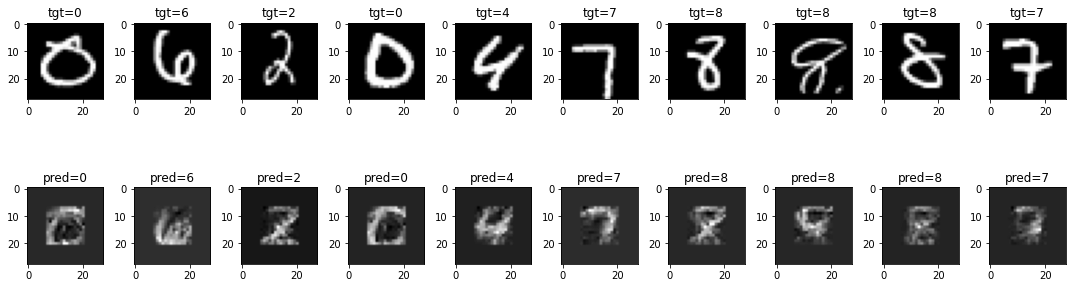

In [ ]:
import torch
import time
import numpy as np

state = torch.load(best_model_path)
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(test_qmnist))
    inp = model(test_qmnist[_][0].unsqueeze(0).to(device))
    o = inv_model(inp)
    img = o.reshape((28, 28)).cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(test_qmnist[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    label = torch.argmax(model(o))
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={test_qmnist[_][1]}')
plt.tight_layout()
sample_save_path = run_path/f'{run_id}_{time.time()}.png'
plt.savefig(sample_save_path)
plt.show()

Now, let's see how identifiable the images generated using reversed model are...

In [ ]:
from tqdm.notebook import tqdm

tgts = []
preds = []
with torch.no_grad():
    for i, test_sample in enumerate(tqdm(test_qmnist)):
        inp = model(test_qmnist[i][0].unsqueeze(0).to(device))
        tgt = test_qmnist[i][1]
        o = inv_model(inp)  # generate image using inverted model
        pred = torch.argmax(torch.softmax(model(o), -1))
        tgts.append(tgt)
        preds.append(pred.item())

print(f'accuracy on generated images = {(np.array(tgts) == np.array(preds)).sum()/len(tgts) * 100}%')

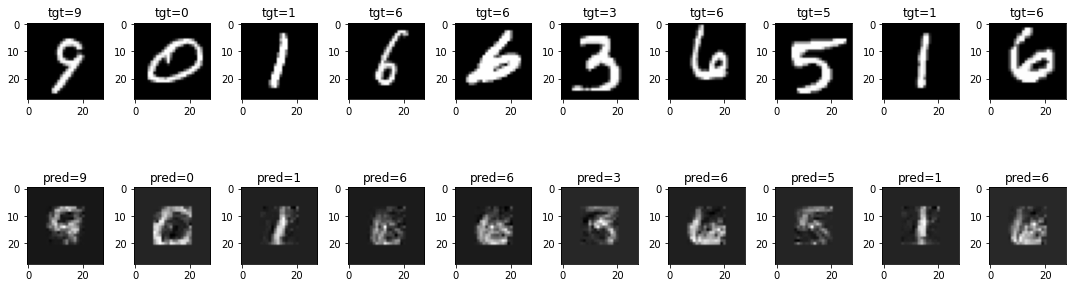

In [ ]:
import torch
import time
import numpy as np

state = torch.load(best_model_path)
inv_model.load_state_dict(state['model_state'])

plt.figure(figsize=(15, 5))
total_plts = 10
for i in range(total_plts):
    _ = np.random.randint(len(train_qmnist))
    inp = model(train_qmnist[_][0].unsqueeze(0).to(device))
    o = inv_model(inp)
    img = o.reshape((28, 28)).cpu().detach().numpy()
    ax_org = plt.subplot(2, 10, i+1)
    plt.imshow(train_qmnist[_][0].squeeze().numpy(), cmap='gray')
    ax_pred = plt.subplot(2, 10, i+1+total_plts) 
    plt.imshow(img, cmap='gray')
    label = torch.argmax(model(o))
    ax_pred.set_title(f'pred={label}')
    ax_org.set_title(f'tgt={train_qmnist[_][1]}')
plt.tight_layout()
sample_save_path = run_path/f'{run_id}_trainSetSamples_{time.time()}.png'
plt.savefig(sample_save_path)
plt.show()

In [20]:
import numpy as np

state = torch.load(best_model_path)
inv_model.load_state_dict(state['model_state'])

for i in range(10):
    _ = np.random.randint(len(train_qmnist))
    inp = model(train_qmnist[_][0].unsqueeze(0).to(device))
    o = inv_model(inp)
    inp_min = torch.min(train_qmnist[_][0])
    inp_max = torch.max(train_qmnist[_][0])
    out_min = torch.min(o).item()
    out_max = torch.max(o).item()
    print(inp_min, inp_max, torch.mean(train_qmnist[_][0]), out_min, out_max, torch.mean(o).item())

tensor(-0.4242) tensor(2.8215) tensor(-0.2288) -0.8699549436569214 3.439634084701538 -0.20680071413516998
tensor(-0.4242) tensor(2.8215) tensor(-0.3280) -0.9457502961158752 2.720094919204712 -0.2874257564544678
tensor(-0.4242) tensor(2.8215) tensor(-0.0176) -1.0619122982025146 3.966275930404663 -0.23099340498447418
tensor(-0.4242) tensor(2.8215) tensor(0.1276) -0.8525776863098145 2.817974328994751 -0.2136584222316742
tensor(-0.4242) tensor(2.8215) tensor(-0.0377) -0.9446045160293579 3.8887317180633545 -0.115816131234169
tensor(-0.4242) tensor(2.8215) tensor(0.1163) -1.1856931447982788 3.363903284072876 -0.14340350031852722
tensor(-0.4242) tensor(2.8215) tensor(-0.0190) -0.9184311032295227 4.131333351135254 -0.15323752164840698
tensor(-0.4242) tensor(2.8215) tensor(-0.1813) -0.9745091199874878 3.6418418884277344 -0.26813673973083496
tensor(-0.4242) tensor(2.8215) tensor(0.1339) -0.8450464606285095 3.486212730407715 -0.2187476009130478
tensor(-0.4242) tensor(2.8215) tensor(0.0310) -1.268